In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import pymc
import pymc.Matplot as pmplot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
columns = ["Match","Date","Radiant","Dire","Winner","Round","Game","Time","Radiant Score","Dire Score"]
df_raw = pd.read_csv('ti5_group_stage_clean.csv', names = columns, skiprows=1)

In [3]:
df_raw.head()

,Match,Date,Radiant,Dire,Winner,Round,Game,Time,Radiant Score,Dire Score
0,1674031017,07/30/15,VP 2,Empire,DIRE,Tiebreaker,3,42.87,9,14
1,1673941543,07/30/15,VP 2,Empire,DIRE,Tiebreaker,2,49.15,19,26
2,1673865688,07/30/15,Empire,VP 2,DIRE,Tiebreaker,1,39.78,11,36
3,1673815749,07/30/15,EHOME,CDEC,DIRE,Group Stage,2,43.77,15,28
4,1673789962,07/30/15,Empire,MVP HOT6,RADIANT,Group Stage,2,29.78,26,13


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 114
Data columns (total 10 columns):
Match            115 non-null int64
Date             115 non-null object
Radiant          115 non-null object
Dire             115 non-null object
Winner           115 non-null object
Round            115 non-null object
Game             115 non-null int64
Time             115 non-null float64
Radiant Score    115 non-null int64
Dire Score       115 non-null int64
dtypes: float64(1), int64(4), object(5)
memory usage: 9.9+ KB


In [5]:
# Need to combine both sets of team names for encoding
set(df_raw.Radiant.unique()) == set(df_raw.Dire.unique())

False

In [6]:
# Encode team names
teams = set(list(df_raw.Radiant.unique()) + list(df_raw.Dire.unique()))
team_dict = dict(zip(teams, range(len(teams))))

In [7]:
team_dict

{'C9': 7,
 'CDEC': 6,
 'EG': 5,
 'EHOME': 4,
 'Empire': 12,
 'Fnatic.MY': 0,
 'LGD.cn': 10,
 'MVP HOT6': 13,
 'MVP Phoenix': 1,
 'NaVi': 3,
 'Nb': 14,
 'Secret': 8,
 'VG': 2,
 'VP 2': 9,
 'coL 2': 11,
 'iG': 15}

In [102]:
team_lookup = dict((v,k) for k, v in team_dict.iteritems())

In [8]:
df_raw.loc[:,'radiant_team_id'] = df_raw.Radiant.apply(lambda x: team_dict[x])
df_raw.loc[:,'dire_team_id'] = df_raw.Dire.apply(lambda x: team_dict[x])

In [9]:
df_raw.head()

,Match,Date,Radiant,Dire,Winner,Round,Game,Time,Radiant Score,Dire Score,radiant_team_id,dire_team_id
0,1674031017,07/30/15,VP 2,Empire,DIRE,Tiebreaker,3,42.87,9,14,9,12
1,1673941543,07/30/15,VP 2,Empire,DIRE,Tiebreaker,2,49.15,19,26,9,12
2,1673865688,07/30/15,Empire,VP 2,DIRE,Tiebreaker,1,39.78,11,36,12,9
3,1673815749,07/30/15,EHOME,CDEC,DIRE,Group Stage,2,43.77,15,28,4,6
4,1673789962,07/30/15,Empire,MVP HOT6,RADIANT,Group Stage,2,29.78,26,13,12,13


In [10]:
np.log(df_raw['Dire Score'] + 1).mean()

3.134049702476196

In [11]:
np.log(df_raw['Radiant Score'] + 1).mean()

3.0473174625051374

In [12]:
np.log(df_raw['Radiant Score'] + df_raw['Dire Score']).mean()

3.8248518886361365

In [13]:
# Most of the time (this patch) top score wins so we'll use
# score differntial as a proxy for winning
winner = (df_raw.Winner == 'RADIANT').values
top_score = (df_raw['Radiant Score'] > df_raw['Dire Score']).values

np.mean([x == y for x,y in zip(winner, top_score)])

0.95652173913043481

In [14]:
observed_radiant_score = df_raw['Radiant Score'].values
observed_dire_score = df_raw['Dire Score'].values
radiant_team = df_raw.radiant_team_id.values
dire_team = df_raw.dire_team_id.values
num_teams = len(teams)
num_games = len(df_raw)

In [15]:
# Initialize values with global means (optional)
att_starting_points = np.log(df_raw.groupby('dire_team_id')['Dire Score'].mean())
def_starting_points = -np.log(df_raw.groupby('dire_team_id')['Radiant Score'].mean())

In [16]:
# Hyperparam Priors
dire = pymc.Normal('dire',0, 0.0001, value = 0)
tau_att = pymc.Gamma('tau_att', 0.1, 0.1, value = 10)
tau_def = pymc.Gamma('tau_def', 0.1, 0.1, value = 10)
intercept = pymc.Normal('intercept',0, 0.0001, value = 0)

In [17]:
# team priors
atts_star = pymc.Normal('atts_star',
                        mu = 0,
                        tau = tau_att,
                        size=num_teams,
                        value=att_starting_points.values)
defs_star = pymc.Normal('defs_star',
                        mu = 0,
                        tau = tau_def,
                        size=num_teams,
                        value=def_starting_points.values)

In [18]:
@pymc.deterministic
def atts(atts_star = atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star = defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pymc.deterministic
def dire_theta(dire_team = dire_team,
               radiant_team = radiant_team,
               dire = dire,
               atts = atts,
               defs = defs,
               intercept = intercept):
    return np.exp(intercept +
                  dire +
                  atts[dire_team] +
                  defs[radiant_team])

@pymc.deterministic
def radiant_theta(dire_team = dire_team,
                  radiant_team = radiant_team,
                  dire = dire,
                  atts = atts,
                  defs = defs,
                  intercept = intercept):
    return np.exp(intercept +
                  atts[radiant_team] +
                  defs[dire_team])

dire_score = pymc.Poisson('dire_score',
                          mu = dire_theta,
                          value = observed_dire_score,
                          observed = True)

radiant_score = pymc.Poisson('radiant_score',
                             mu = radiant_theta,
                             value = observed_radiant_score,
                             observed = True)

mcmc = pymc.MCMC([dire, intercept, tau_att, tau_def,
                  dire_theta, radiant_theta, atts_star,
                  defs_star, atts,defs, dire_score,
                  radiant_score])

In [19]:
#map_= pymc.MAP(mcmc)
#map_.fit()
mcmc.sample(250000, 80000, 20)

 [-----------------100%-----------------] 250000 of 250000 complete in 109.8 sec

Plotting dire
Plotting tau_def
Plotting intercept
Plotting tau_att


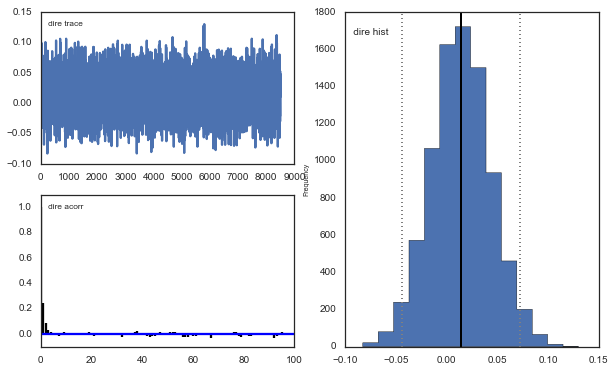

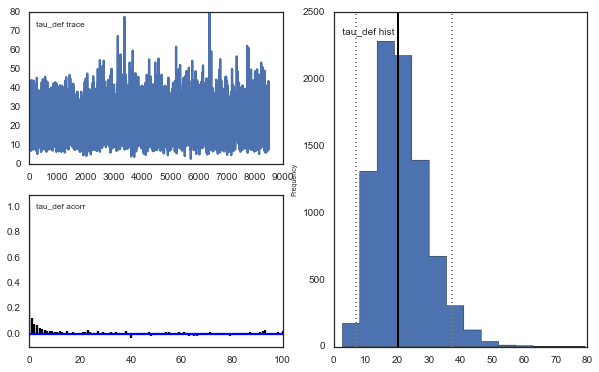

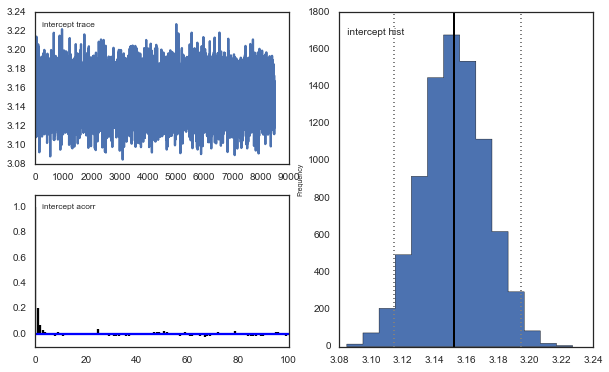

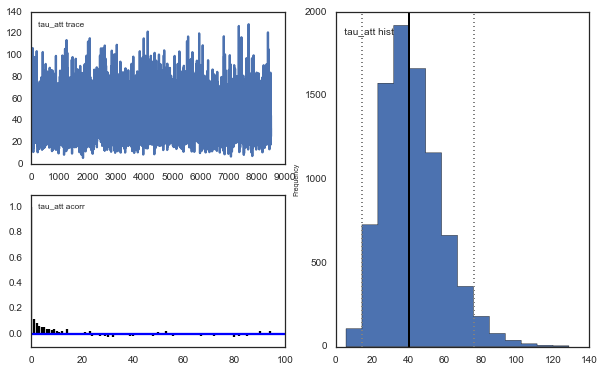

In [20]:
pmplot.plot(mcmc)

In [21]:
team_dict

{'C9': 7,
 'CDEC': 6,
 'EG': 5,
 'EHOME': 4,
 'Empire': 12,
 'Fnatic.MY': 0,
 'LGD.cn': 10,
 'MVP HOT6': 13,
 'MVP Phoenix': 1,
 'NaVi': 3,
 'Nb': 14,
 'Secret': 8,
 'VG': 2,
 'VP 2': 9,
 'coL 2': 11,
 'iG': 15}

In [22]:
sorted(team_dict,key =  team_dict.get)

['Fnatic.MY',
 'MVP Phoenix',
 'VG',
 'NaVi',
 'EHOME',
 'EG',
 'CDEC',
 'C9',
 'Secret',
 'VP 2',
 'LGD.cn',
 'coL 2',
 'Empire',
 'MVP HOT6',
 'Nb',
 'iG']

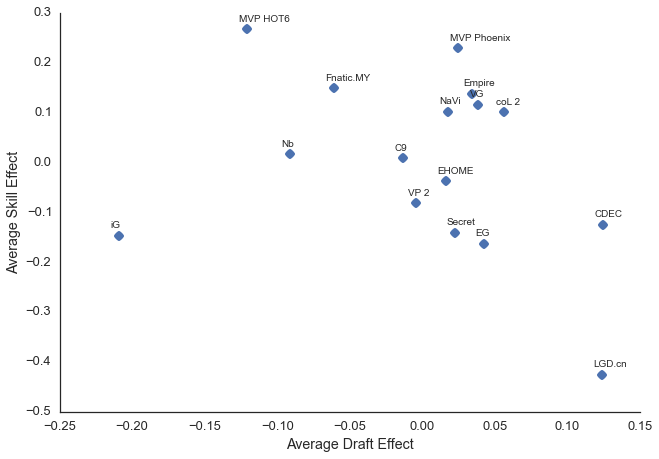

In [23]:
# Good way to look at team strength
df_avg = pd.DataFrame({'avg_att': atts.stats()['mean'],
                       'avg_def': defs.stats()['mean']},
                      index=sorted(team_dict,key =  team_dict.get))

fig, ax = plt.subplots()

ax.plot(df_avg.avg_att,df_avg.avg_def,'o')
for row in df_avg.iterrows():
    ax.annotate(row[0],xy=tuple(row[1]), xytext = (-8, 8), textcoords = 'offset points')
plt.xlabel('Average Draft Effect')
plt.ylabel('Average Skill Effect')
sns.despine()

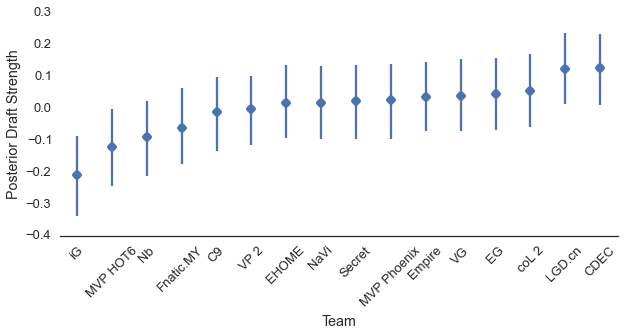

In [24]:
df_hpd = pd.DataFrame((atts.stats()['95% HPD interval']).T,
                      columns=['hpd_low','hpd_high'],
                      index=sorted(team_dict,key =  team_dict.get))

df_median = pd.DataFrame((atts.stats()['quantiles'][50]),
                      columns=['hpd_median'],
                      index=sorted(team_dict,key =  team_dict.get))

df_hpd = df_hpd.merge(df_median, left_index=True, right_index=True)
df_hpd.loc[:,'relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd.loc[:,'relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median

df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + 0.5
fig, axs = plt.subplots(figsize=(10,4))

axs.errorbar(df_hpd['x'],
            df_hpd.hpd_median,
            yerr=(df_hpd[['relative_lower','relative_upper']].values).T,
            fmt='o')

plt.xlabel('Team')
plt.ylabel('Posterior Draft Strength')
axs.set_xticks(df_hpd['x'])
axs.set_xticklabels(df_hpd['index'].values, rotation = 45)
sns.despine(left = True)

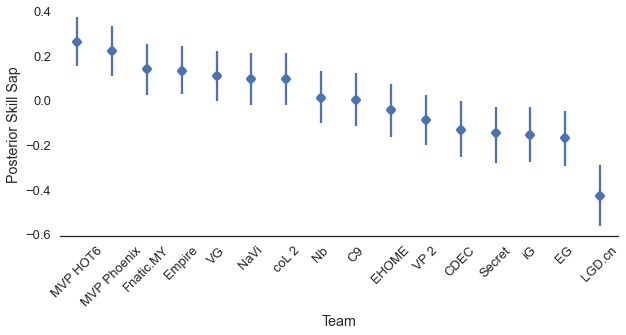

In [25]:
df_hpd = pd.DataFrame((defs.stats()['95% HPD interval']).T,
                      columns=['hpd_low','hpd_high'],
                      index=sorted(team_dict,key =  team_dict.get))

df_median = pd.DataFrame((defs.stats()['quantiles'][50]),
                      columns=['hpd_median'],
                      index=sorted(team_dict,key =  team_dict.get))

df_hpd = df_hpd.merge(df_median, left_index=True, right_index=True)
df_hpd.loc[:,'relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd.loc[:,'relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median

df_hpd = df_hpd.sort_index(by='hpd_median', ascending = False)
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + 0.5
fig, axs = plt.subplots(figsize=(10,4))

axs.errorbar(df_hpd['x'],
            df_hpd.hpd_median,
            yerr=(df_hpd[['relative_lower','relative_upper']].values).T,
            fmt='o')

plt.xlabel('Team')
plt.ylabel('Posterior Skill Sap')
axs.set_xticks(df_hpd['x'])
axs.set_xticklabels(df_hpd['index'].values, rotation = 45)
sns.despine(left = True)

In [26]:
#def get_dire_theta(intercept, dire, atts, defs):
#    return np.exp(intercept + dire + atts + defs)

def get_dire_theta(intercept, dire, atts, defs):
    return np.exp(intercept + dire + atts + defs)

def get_radiant_theta(intercept, atts, defs):
    return np.exp(intercept + atts + defs)

def get_score(theta):
    return np.random.poisson(theta)

In [27]:
atts_trace = atts.trace()
defs_trace = defs.trace()
dire_trace = dire.trace()
intercept_trace = intercept.trace()

In [85]:
from collections import Counter
import operator

def simulate_match(dire_team,radiant_team):
    # draw samples
    num_samples = len(atts_trace)
    draw = np.random.randint(0,num_samples)
    
    # draw for the given two teams
    dire_att = atts_trace[draw,dire_team]
    radiant_att = atts_trace[draw,radiant_team]
    dire_defs = defs_trace[draw,dire_team]
    radiant_defs = defs_trace[draw,radiant_team]
    
    intercept_draw = intercept_trace[draw]
    dire_draw = dire_trace[draw]
    
    # Collect latent strengths
    dire_thetas = get_dire_theta(intercept_draw,
                                 dire_draw,
                                 dire_att,
                                 radiant_defs)
    
    radiant_thetas = get_radiant_theta(intercept_draw,
                                        radiant_att,
                                        dire_defs)
    
    # Generate scores
    dire_scores = get_score(dire_thetas)
    radiant_scores = get_score(radiant_thetas)
    
    # Call a winner (probability dire wins)
    if dire_scores >= radiant_scores:
        return dire_team
    else:
        return radiant_team

def simulate_series(team_one, team_two, n = 3):
    # flip to see who is dire
    dire_team = np.random.choice([team_one, team_two])
    if dire_team == team_one:
        radiant_team = team_two
    else:
        radiant_team = team_one
    
    winner = []
    for game in xrange(n):
        winner.append(simulate_match(dire_team, radiant_team))
        dire_team, radiant_team = radiant_team, dire_team
        
    wins = Counter(winner)
    
    # find who won the most
    return max(wins.iteritems(), key=operator.itemgetter(1))[0]

def predict_winner(t1,t2,n = 3, sims = 10000):
    win_count = Counter([simulate_series(t1,t2,n) for _ in xrange(sims)])
    win_team, num_wins = max(win_count.iteritems(), key=operator.itemgetter(1))
    return win_team
    print 'Team %d wins with probability %0.2f' % (win_team, num_wins / sims)

In [248]:
games = [(10,12),(6,7),(1,14),(2,3),(9,0),(15,13)]

for g in games:
    predict_winner(g[0],g[1])

Team 10 wins with probability 1.00
Team 6 wins with probability 0.89
Team 14 wins with probability 0.69
Team 2 wins with probability 0.53
Team 9 wins with probability 0.91
Team 15 wins with probability 0.91


In [249]:
games = [(5,11),(8,4),(12,1),(7,2)]

for g in games:
    predict_winner(g[0],g[1])

Team 5 wins with probability 0.88
Team 8 wins with probability 0.67
Team 12 wins with probability 0.70
Team 7 wins with probability 0.58


In [250]:
games = [(11,9),(8,15),(10,6),(5,4)]

for g in games:
    predict_winner(g[0],g[1])

Team 9 wins with probability 0.72
Team 8 wins with probability 0.83
Team 10 wins with probability 0.89
Team 5 wins with probability 0.78


In [251]:
games = [(1,2),(9,8),(2,4)]

for g in games:
    predict_winner(g[0],g[1])

Team 2 wins with probability 0.74
Team 8 wins with probability 0.63
Team 4 wins with probability 0.74


In [31]:
games = [(10,9),(6,5), (2,10)]

for g in games:
    predict_winner(g[0],g[1])

Team 10 wins with probability 0.97
Team 6 wins with probability 0.59
Team 10 wins with probability 1.00


In [30]:
predict_winner(10,5)

Team 10 wins with probability 0.92


In [32]:
predict_winner(6,10, n=5)

Team 10 wins with probability 0.94


In [86]:
from collections import defaultdict

def slot_dict(winner, loser, team_1 = None, team_2 = None):
    return {'winner':winner,
            'loser':loser,
            'team_1':team_1,
            'team_2':team_2}

def make_bracket_dict():
    '''
    Bracket start:
    LGD v. Empire (10:12)
    CDEC v. C9 (6:7)
    EG v. coL (5:11)
    Secret v. EHOME (8:4)

    MVP.Phx v. Newbee (1:14)
    VG v. Na'Vi (2:3)
    VP v. Fnatic (9:0)
    iG v. MVP.Hot6 (15:13)
    '''
    
    places = ['1','2','3','4','5-6','7-8','9-12','13-16']
    seed_spots = ['LB1A','LB1B','LB1C','LB1D',
                  'UB1A','UB1B','UB1C','UB1D']
    seed_tuples = [(1,14),(2,3),(9,0),(15,13),
                   (10,12),(6,7),(5,11),(8,4)]
    
    lower_bracket = [('LB1A','LB2A','13-16'),
                     ('LB1B','LB2B','13-16'),
                     ('LB1C','LB2C','13-16'),
                     ('LB1D','LB2D','13-16'),
                     ('LB2A','LB3A','9-12'), ('LB2B','LB3A','9-12'),
                     ('LB2C','LB3B','9-12'), ('LB2D','LB3B','9-12'),
                     ('LB3A','LB4A','7-8'),
                     ('LB3B','LB4B','7-8'),
                     ('LB4A','LB5A','5-6'), ('LB4B','LB5A','5-6'),
                     ('LB5A','LBF','4'),
                     ('LBF','GF','3')]
    
    upper_bracket = [('UB1A','UB2A','LB2A'),
                     ('UB1B','UB2A','LB2B'),
                     ('UB1C','UB2B','LB2C'),
                     ('UB1D','UB2B','LB2D'),
                     ('UB2A','UBF','LB4B'), ('UB2B','UBF','LB4A'),
                     ('UBF','GF','LBF'),('GF','1','2')]
    
    bracket_tuples = lower_bracket + upper_bracket
    
    bracket_dict = defaultdict(dict)
    
    for place in places:
        bracket_dict[place] = []
    
    for slot,winner,loser in bracket_tuples:
        bracket_dict[slot] = slot_dict(winner, loser)
        
    # Seed
    for teams, slot in zip(seed_tuples, seed_spots):
        bracket_dict[slot].update({'team_1':teams[0],'team_2':teams[1]})
    
    return bracket_dict

def send_team(team, slot, brack):
    # Is this a terminal bracket?
    if slot in ['1','2','3','4','5-6','7-8','9-12','13-16']:
        brack[slot].append(team)
    # check for the missing team
    elif brack[slot]['team_1'] == None:
        brack[slot].update({'team_1':team})
    else:
        brack[slot].update({'team_2':team})

    return brack
    

def simulate_bracket():
    match_progression = ['UB1A','UB1B','LB1A','LB1B','LB1C','LB1D',
                         'UB1C','UB1D','LB2A','LB2B',
                         'LB2C','LB2D','UB2A','UB2B',
                         'LB3A','LB3B','LB4A',
                         'LB4B','UBF','LB5A',
                         'LBF','GF']
    # get starting bracket
    bracket = make_bracket_dict()
    
    n = 3
    for match in match_progression:
        # if this is Grand Finals make BO 5
        if match == 'GF':
            n = 5
        # Grab this match from bracket
        match_dict = bracket[match]
        # simulate match
        winner = predict_winner(match_dict['team_1'],match_dict['team_2'], n, 1)
        if match_dict['team_1'] == winner:
            loser = match_dict['team_2']
        else:
            loser = match_dict['team_1']
        # Send the teams to the right places
        bracket = send_team(winner, match_dict['winner'], bracket)
        bracket = send_team(loser, match_dict['loser'], bracket)
        
    return bracket

def oracle(n_samples = 1000):
    '''
    simulates n_samples brackets and collects the placement counts for each team
    '''
    team_dict = defaultdict(list)
    places = ['1','2','3','4','5-6','7-8','9-12','13-16']
    
    for _ in xrange(n_samples):
        curr_bracket = simulate_bracket()
        # go through finishing places and append place to team
        for place in places:
            for t in curr_bracket[place]:
                team_dict[t].append(place)
    
    for t, results in team_dict.iteritems():
        team_dict[t] = Counter(results)
        
    return team_dict

In [155]:
team_results = oracle(n_samples=10000)

In [156]:
df_team_results = pd.DataFrame(team_results).loc[places].transpose().fillna(0)
df_team_results['team'] = team_lookup.values()
df_prob = df_team_results.set_index('team').apply(lambda x: x / sum(x), axis = 1)

In [157]:
df_prob

,1,2,3,4,5-6,7-8,9-12,13-16
team,,,,,,,,
Fnatic.MY,0.0000,0.0000,0.0000,0.0000,0.0026,0.0159,0.0812,0.9003
MVP Phoenix,0.0000,0.0000,0.0001,0.0011,0.0179,0.0819,0.2272,0.6718
VG,0.0000,0.0001,0.0010,0.0178,0.0825,0.0743,0.3387,0.4856
NaVi,0.0000,0.0002,0.0013,0.0176,0.0734,0.0758,0.3173,0.5144
EHOME,0.0005,0.0383,0.1102,0.1506,0.2715,0.2311,0.1978,0.0000
EG,0.0214,0.3657,0.3140,0.1545,0.0870,0.0255,0.0319,0.0000
CDEC,0.0279,0.3383,0.2280,0.1882,0.2067,0.0037,0.0072,0.0000
C9,0.0000,0.0046,0.0167,0.1069,0.3535,0.1815,0.3368,0.0000
Secret,0.0055,0.1984,0.2631,0.2036,0.1938,0.0835,0.0521,0.0000


In [158]:
def likely_endings(df):
    seen_teams = []
    
    first_place = df['1'].idxmax()
    seen_teams.append(first_place)
    mask = ~df.index.isin(seen_teams)
    
    second_place = df.loc[mask,'2'].idxmax()    
    seen_teams.append(second_place)
    mask = ~df.index.isin(seen_teams)
    
    third_place = df.loc[mask,'3'].idxmax()    
    seen_teams.append(third_place)
    mask = ~df.index.isin(seen_teams)
                          
    fourth_place = df.loc[mask,'4'].idxmax()    
    seen_teams.append(fourth_place)
    mask = ~df.index.isin(seen_teams)
    
    five_six_place = list(df_prob.loc[mask,'5-6'].order().tail(2).index.values)
    seen_teams = seen_teams + five_six_place
    mask = ~df.index.isin(seen_teams)
    
    seven_eight_place = list(df_prob.loc[mask,'7-8'].order().tail(2).index.values)
    seen_teams = seen_teams + seven_eight_place
    mask = ~df.index.isin(seen_teams)
    
    nine_twelve_place = list(df_prob.loc[mask,'9-12'].order().tail(4).index.values)
    seen_teams = seen_teams + nine_twelve_place
    mask = ~df.index.isin(seen_teams)
    
    thirt_six_place = list(df_prob.loc[mask,'13-16'].order().tail(4).index.values)
    
    print 'Winner: %s' % first_place
    print 'Runner Up: %s' % second_place
    print '3rd: %s' % third_place
    print '4th: %s' % fourth_place
    print '5-6: %s, %s' % tuple(five_six_place)
    print '7-8: %s, %s' % tuple(seven_eight_place)
    print '9-12: %s, %s, %s, %s' % tuple(nine_twelve_place)
    print '13-16: %s, %s, %s, %s' % tuple(thirt_six_place)
    

In [159]:
likely_endings(df_prob)

Winner: LGD.cn
Runner Up: EG
3rd: Secret
4th: CDEC
5-6: EHOME, C9
7-8: VP 2, Empire
9-12: VG, Nb, coL 2, iG
13-16: NaVi, MVP Phoenix, Fnatic.MY, MVP HOT6
